# Run From Directories Example

In [29]:
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import useq
from rich import print
from sqlmodel import Session, create_engine, select

from cali.analysis import AnalysisRunner
from cali.readers import TensorstoreZarrReader
from cali.sqlmodel import (
    FOV,
    ROI,
    AnalysisSettings,
    Experiment,
    Traces,
    print_experiment_tree,
    useq_plate_plan_to_db,
)

In [33]:
# path to the data and the segmentation labels
data_path = (
    "/Users/fdrgsp/Documents/git/cali/tests/test_data/evoked/evk.tensorstore.zarr"
)
labels_path = "/Users/fdrgsp/Documents/git/cali/tests/test_data/evoked/evk_labels"

# path to save analysis results
analysis_path = "/Users/fdrgsp/Desktop/cali_test"

In [37]:
# create a new experiment
exp = Experiment(
    id=0,
    name="New Experiment",
    description="A Test Experiment.",
    created_at=datetime.now(),
    database_name="cali_new.db",
    data_path=data_path,
    labels_path=labels_path,
    analysis_path=analysis_path,
)
print_experiment_tree(exp, max_level="experiment")

🧪 New Experiment
├── Experiment Type: Spontaneous Activity
└── A Test Experiment.

In [38]:
# load the data and get the useq plate plan from the sequence
data = TensorstoreZarrReader(exp.data_path)
assert data.sequence is not None
plate_plan = data.sequence.stage_positions
assert isinstance(plate_plan, useq.WellPlatePlan)

# Define plate maps for conditions (optional)
plate_maps = {
    "genotype": {"B5": "WT"},
    "treatment": {"B5": "Vehicle"},
}

# Create plate (optional - with plate_maps)
plate = useq_plate_plan_to_db(plate_plan, exp, plate_maps)
exp.plate = plate

print_experiment_tree(exp)

🧪 New Experiment
├── Experiment Type: Spontaneous Activity
├── A Test Experiment.
└── 📋 96-well (96-well)
    └── 🧫 B5 - 🧪 Conditions: WT, Vehicle

In [39]:
# define analysis settings
analysis_settings = AnalysisSettings(
    experiment_id=exp.id,
    created_at=datetime.now(),
    dff_window=150,
    threads=5,
    # the rest are defaults
)
# assign analysis settings to experiment
exp.analysis_settings = analysis_settings

print_experiment_tree(exp)

🧪 New Experiment
├── Experiment Type: Spontaneous Activity
├── A Test Experiment.
├── ⚙️ Analysis Settings available
└── 📋 96-well (96-well)
    └── 🧫 B5 - 🧪 Conditions: WT, Vehicle

In [41]:
# specify all positions to be analyzed
exp.positions_analyzed = list(range(len(plate_plan)))
# exp.positions_analyzed = [0, 1]
print(f"Positions to analyze: {exp.positions_analyzed}")

Positions to analyze: [0]

In [42]:
analysis = AnalysisRunner()

# Using the Experiment info, this automatically sets the analysis settings (if any) and
# loads the data (if the experiment has a data path).
#
# If you want to only update the analysis settings, you can use:
# runner.update_settings(analysis_settings).
#
# If you want to to only set the data you can use:
# runner.set_data(data) - (where data is a path, a str or cali reader)
analysis.set_experiment(exp)
assert analysis.data() is not None

2025-11-12 11:15:21,228 - cali_logger - INFO - 💾 Experiment analysis updated and saved to database at /Users/fdrgsp/Desktop/cali_test/cali_new.db.


In [43]:
print_experiment_tree(analysis.experiment())

🧪 New Experiment
├── Experiment Type: Spontaneous Activity
├── A Test Experiment.
├── ⚙️ Analysis Settings available
└── 📋 96-well (96-well)
    └── 🧫 B5 - 🧪 Conditions: WT, Vehicle

In [ ]:
# run the analysis
analysis.run()

2025-11-12 10:51:32,262 - cali_logger - INFO - Starting Analysis...
2025-11-12 10:51:32,272 - cali_logger - INFO - Starting traces analysis...
2025-11-12 10:51:32,274 - cali_logger - INFO - Number of threads for analysis: 5
2025-11-12 10:51:32,275 - cali_logger - INFO - Positions to analyze: [0]
2025-11-12 10:51:32,297 - cali_logger - INFO - Extracting Traces Data from Well B5_0000_p0.
Extracting Traces Data from Well B5_0000_p0.:   0%|          | 0/4 [00:00<?, ?it/s]/Users/fdrgsp/Documents/git/cali/.venv/lib/python3.13/site-packages/oasis/functions.py:849: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 153, using nperseg = 153
  ff, Pxx = scipy.signal.welch(y)
/Users/fdrgsp/Documents/git/cali/.venv/lib/python3.13/site-packages/oasis/functions.py:817: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `

In [19]:
# get the updated experiment with analysis results
exp = analysis.experiment()
print_experiment_tree(exp, max_level="fov")

🧪 New Experiment
├── Experiment Type: Spontaneous Activity
├── A Test Experiment.
├── ⚙️ Analysis Settings available
└── 📋 96-well (96-well)
    └── 🧫 B5 - 🧪 Conditions: WT, Vehicle
        └── 📷 B5_0000_p0 (fov: 0 - pos: 0)

In [20]:
# analyze specific positions only
analysis.set_positions_to_analyze([0])  # [3, 5, 15, ...]

2025-11-12 10:53:08,456 - cali_logger - INFO - ✅ Validated positions [0] (data has 1 positions total)
2025-11-12 10:53:08,459 - cali_logger - INFO - 💾 Positions to analyze updated: [0] in database at /Users/fdrgsp/Desktop/cali_test/cali_new.db


In [21]:
# run the analysis again on the new positions
analysis.run()

2025-11-12 10:53:09,709 - cali_logger - INFO - Starting Analysis...
2025-11-12 10:53:09,717 - cali_logger - INFO - Starting traces analysis...
2025-11-12 10:53:09,724 - cali_logger - INFO - Number of threads for analysis: 5
2025-11-12 10:53:09,724 - cali_logger - INFO - Positions to analyze: [0]
2025-11-12 10:53:09,762 - cali_logger - INFO - Extracting Traces Data from Well B5_0000_p0.
Extracting Traces Data from Well B5_0000_p0.: 100%|██████████| 4/4 [00:00<00:00, 195.75it/s]
2025-11-12 10:53:09,786 - cali_logger - INFO - 💾 Updated analysis data for position 0 in database.
2025-11-12 10:53:09,786 - cali_logger - INFO - Analysis Finished.


In [22]:
# get the updated experiment with analysis results
exp = analysis.experiment()
print_experiment_tree(exp, max_level="fov")

🧪 New Experiment
├── Experiment Type: Spontaneous Activity
├── A Test Experiment.
├── ⚙️ Analysis Settings available
└── 📋 96-well (96-well)
    └── 🧫 B5 - 🧪 Conditions: WT, Vehicle
        └── 📷 B5_0000_p0 (fov: 0 - pos: 0)

In [23]:
# Create new analysis settings with different parameters
analysis_settings_new = AnalysisSettings(
    experiment_id=exp.id,
    created_at=datetime.now(),
    threads=10,
    dff_window=100,
    # the rest are defaults
)

# Update the analysis settings
analysis.update_settings(analysis_settings_new)

2025-11-12 10:53:21,169 - cali_logger - INFO - 💾 Analysis settings updated in database at /Users/fdrgsp/Desktop/cali_test/cali_new.db


In [24]:
# specify new positions to be analyzed
analysis.set_positions_to_analyze([0])

2025-11-12 10:53:27,316 - cali_logger - INFO - ✅ Validated positions [0] (data has 1 positions total)
2025-11-12 10:53:27,318 - cali_logger - INFO - 💾 Positions to analyze updated: [0] in database at /Users/fdrgsp/Desktop/cali_test/cali_new.db


In [25]:
# Clear previous analysis results. This is optional but recommended to avoid
# to have different positions analyzed with different settings.
analysis.clear_analysis_results()
# run the analysis
analysis.run()

2025-11-12 10:53:30,196 - cali_logger - INFO - Deleting 1 FOVs and their associated analysis data...
2025-11-12 10:53:30,203 - cali_logger - INFO - 💾 Analysis results cleared from database.
2025-11-12 10:53:30,204 - cali_logger - INFO - Starting Analysis...
2025-11-12 10:53:30,207 - cali_logger - INFO - Starting traces analysis...
2025-11-12 10:53:30,209 - cali_logger - INFO - Number of threads for analysis: 10
2025-11-12 10:53:30,210 - cali_logger - INFO - Positions to analyze: [0]
2025-11-12 10:53:30,234 - cali_logger - INFO - Extracting Traces Data from Well B5_0000_p0.
Extracting Traces Data from Well B5_0000_p0.: 100%|██████████| 4/4 [00:00<00:00, 210.24it/s]
2025-11-12 10:53:30,259 - cali_logger - INFO - 💾 Updated analysis data for position 0 in database.
2025-11-12 10:53:30,259 - cali_logger - INFO - Analysis Finished.


In [26]:
# get the updated experiment with analysis results
exp = analysis.experiment()
print_experiment_tree(exp, max_level="fov")

🧪 New Experiment
├── Experiment Type: Spontaneous Activity
├── A Test Experiment.
├── ⚙️ Analysis Settings available
└── 📋 96-well (96-well)
    └── 🧫 B5 - 🧪 Conditions: WT, Vehicle
        └── 📷 B5_0000_p0 (fov: 0 - pos: 0)

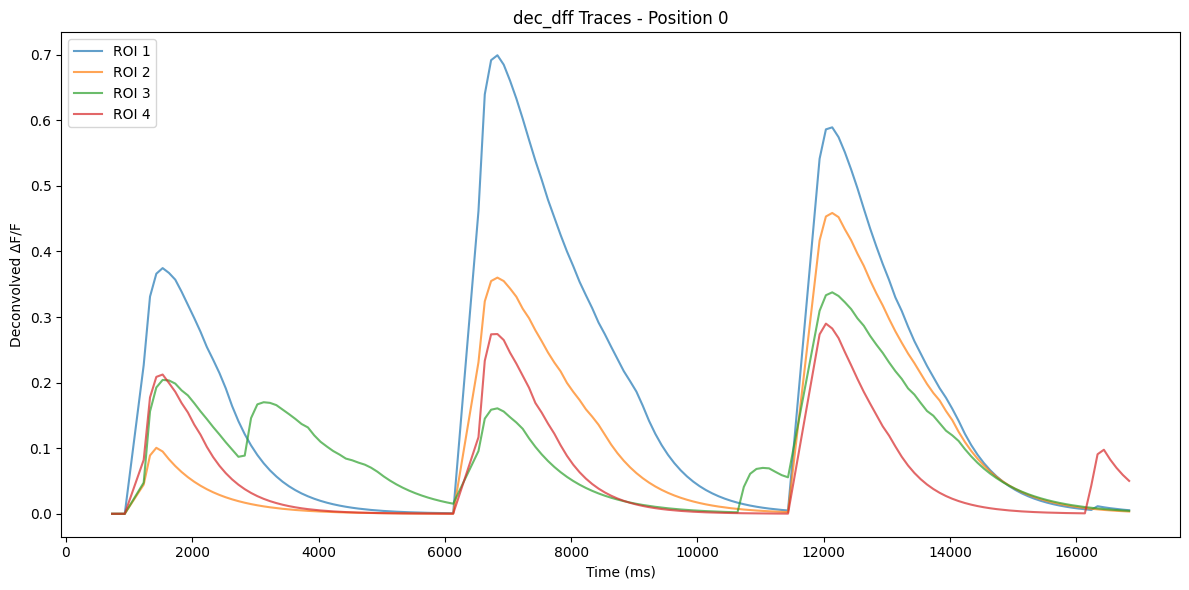

In [32]:
# Plot example

db_path = Path(f"{exp.analysis_path}") / exp.database_name
engine = create_engine(f"sqlite:///{db_path}")

# Query all traces for position 0 in a single efficient query
with Session(engine) as session:
    # Join Traces -> ROI -> FOV and filter by position_index
    statement = (
        select(Traces).join(ROI).join(FOV).where(FOV.position_index == 0)
        # .where(ROI.label_value == 2)
    )

    traces_list = session.exec(statement).all()

    # Plot all dec_dff traces
    fig, ax = plt.subplots(figsize=(12, 6))

    for trace in traces_list:
        if trace.dec_dff is not None:
            # Use x_axis if available, otherwise use frame numbers
            x_data = (
                trace.x_axis
                if trace.x_axis is not None
                else list(range(len(trace.dec_dff)))
            )
            ax.plot(
                x_data,
                trace.dec_dff,
                label=f"ROI {trace.roi.label_value}",
                alpha=0.7,
            )

    x_label = "Time (ms)" if traces_list and traces_list[0].x_axis else "Frame"
    ax.set_xlabel(x_label)
    ax.set_ylabel("Deconvolved ΔF/F")
    ax.set_title("dec_dff Traces - Position 0")
    ax.legend(loc="upper left")
    plt.tight_layout()
    plt.show()